In [4]:
import matplotlib.pyplot as plt
import pyGMs as gm
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import pyro.poutine as poutine

import pandas as pd

seed = 123
pyro.set_rng_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [106]:
data = pd.read_csv('data.csv')

data = data[["winner", "loser"]]
data["win"] = .1

In [124]:
dataset = list(data.itertuples(index=False, name=None))

teams = set()
for match in dataset:
    teams.add(match[0])
    teams.add(match[1])

teams = {v: i for i, v in enumerate(list(teams))}
dataset = [(teams[winner], teams[loser], win)
           for winner, loser, win in dataset]

In [108]:
def model(matches, n_teams):
    X = [pyro.sample(f"X{i}", dist.Normal(0, 1)) for i in range(n_teams)]

    for i, m in enumerate(matches):
        pyro.sample(f"w{i}",
                    dist.Bernoulli(logits=X[m[0]]-X[m[1]]),
                    obs=torch.tensor(1.))

In [109]:
nuts_kernel = pyro.infer.NUTS(model, jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=2000,
                       warmup_steps=100, num_chains=1)
mcmc.run(dataset, len(teams))

Sample: 100%|██████████| 60/60 [00:51,  1.16it/s, step size=2.51e-01, acc. prob=0.763]


In [135]:
score_board = [0]*len(teams)

for m in dataset:
    score_board[m[0]] += 1
    score_board[m[1]] -= 1

score_board = sorted(list(enumerate(score_board)),
                     key=lambda x: x[1], reverse=True)

naive_ranking = [x[0] for x in score_board]

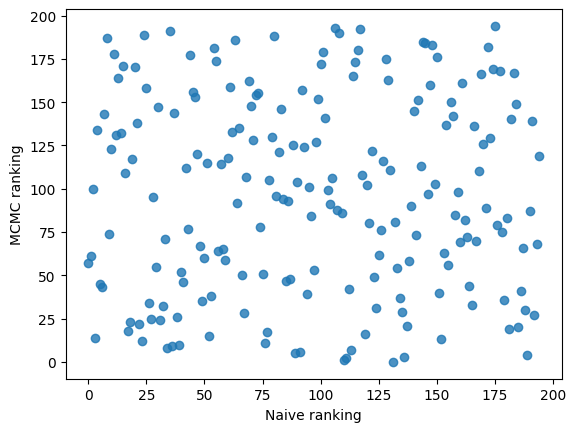

In [152]:
samples = mcmc.get_samples(10000)
mcmc_ranking = sorted(
    naive_ranking, key=lambda i: samples[f'X{i}'].mean(), reverse=True)

plt.plot(naive_ranking, mcmc_ranking, 'o', alpha=0.8, label="Naive")
plt.xlabel("Naive ranking")
plt.ylabel("MCMC ranking")

plt.show()

In [6]:
# Convert to DataFrame
data = pd.read_csv('data.csv')
df = pd.DataFrame(data)

# Create matches list
matches = []
for idx, row in df.iterrows():
    matches.append((row['winner'], row['loser'], 1))

# Modified model with unique sample names
def model(matches):
    skills = {}
    for idx, match in enumerate(matches):
        i, j, w = match
        if i not in skills:
            skills[i] = pyro.sample(f"X_{i}", dist.Normal(0.0, 1.0))
        if j not in skills:
            skills[j] = pyro.sample(f"X_{j}", dist.Normal(0.0, 1.0))
        
        X_i = skills[i]
        X_j = skills[j]
        
        prob_winning = torch.sigmoid(X_i - X_j)
        pyro.sample(f"W_{idx}_{i}_{j}", dist.Bernoulli(prob_winning), obs=torch.tensor(float(w)))

def run_nuts(matches, warmup_steps=100, num_samples=2000):
    nuts_kernel = pyro.infer.NUTS(model)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run(matches)
    return mcmc.get_samples()

# Run the model
samples = run_nuts(matches)

# Extract and analyze samples
for key in samples.keys():
    print(f'{key}: mean={torch.mean(samples[key].float()).item()}, std={torch.std(samples[key].float()).item()}')

# Compare players
skills = {k: torch.mean(v.float()).item() for k, v in samples.items()}
sorted_skills = sorted(skills.items(), key=lambda item: item[1], reverse=True)

print("Player Rankings:")
for player, skill in sorted_skills:
    print(f'{player}: {skill}')

Sample: 100%|█| 2100/2100 [2:56:26,  5.04s/it, step size=3.87e-01, acc. prob=0.8

X_0388741d2158d6e1: mean=-0.2964998185634613, std=0.5295290350914001
X_03cb4ec1d468d591: mean=-0.6120151281356812, std=0.6532904505729675
X_0541226c22da3aab: mean=0.37333351373672485, std=0.521033525466919
X_059fb328bd9a7106: mean=-0.7044523358345032, std=0.721574068069458
X_0844adab2e650e07: mean=-0.8346813917160034, std=0.6296562552452087
X_0a1585de9ecca0bc: mean=0.9093072414398193, std=0.6000796556472778
X_0b2278e6906fe20a: mean=0.009344442747533321, std=0.46479201316833496
X_0b3b107aa68048d9: mean=0.199590265750885, std=0.43020620942115784
X_0eabb6f9e432f01e: mean=1.7358266115188599, std=0.5780270099639893
X_0f1aa4a556467be8: mean=0.09117921441793442, std=0.5256825089454651
X_10493e9d37863786: mean=-1.0606203079223633, std=0.8013028502464294
X_11aae39c4c2ffe00: mean=-0.5917937159538269, std=0.5193546414375305
X_16817cd9a8d557ef: mean=-0.6765599846839905, std=0.5852249264717102
X_1815e7d21ae583de: mean=0.9587898850440979, std=0.5062316656112671
X_18d53bcee4049609: mean=0.63271814584